# LFP Cleaning

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats


In [5]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
from scipy.signal import butter, filtfilt, hilbert

In [9]:
FONTSIZE = 20

In [10]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [11]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

In [157]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    """
    result = array.copy()
    result[mask] = value
    return result

## Inputs & Data

Explanation of each input and where it comes from.

In [13]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [14]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [15]:
VOLTAGE_SCALING_VALUE = 0.195

In [16]:
zscore_threshold = 3

In [17]:
LFP_TRACES_DF = pd.read_pickle("./proc/rce_pilot_2_01_lfp_traces_and_frames.pkl")

In [18]:
LFP_TRACES_DF.shape

(61, 23)

## Preprocessing

In [19]:
original_trace_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col]

In [20]:
original_trace_columns

['mPFC_lfp_trace',
 'MD_lfp_trace',
 'LH_lfp_trace',
 'BLA_lfp_trace',
 'vHPC_lfp_trace']

In [21]:
for col in original_trace_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: x.astype(np.float32) * VOLTAGE_SCALING_VALUE)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [22]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,lfp_timestamps,mPFC_lfp_trace,MD_lfp_trace,LH_lfp_trace,BLA_lfp_trace,vHPC_lfp_trace
0,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[95.354996, 82.09499, 97.5, 132.405, 123.825, ...","[46.019997, 49.335, 75.27, 97.89, 77.61, 40.55...","[61.425, 66.104996, 81.899994, 90.479996, 71.5...","[54.6, 54.405, 73.32, 86.189995, 59.085, 19.89...","[55.574997, 79.365, 128.11499, 170.43, 189.344..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[95.354996, 82.09499, 97.5, 132.405, 123.825, ...","[46.019997, 49.335, 75.27, 97.89, 77.61, 40.55...","[61.425, 66.104996, 81.899994, 90.479996, 71.5...","[54.6, 54.405, 73.32, 86.189995, 59.085, 19.89...","[55.574997, 79.365, 128.11499, 170.43, 189.344..."
2,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[19.89, 29.445, 33.149998, 37.829998, 45.43499...","[29.445, 28.859999, 25.935, 23.205, 21.449999,...","[28.47, 25.349998, 22.035, 22.814999, 23.00999...","[68.64, 90.284996, 93.795, 71.564995, 90.09, 1...","[62.984997, 86.774994, 104.13, 86.96999, 75.65..."
3,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[19.89, 29.445, 33.149998, 37.829998, 45.43499...","[29.445, 28.859999, 25.935, 23.205, 21.449999,...","[28.47, 25.349998, 22.035, 22.814999, 23.00999...","[68.64, 90.284996, 93.795, 71.564995, 90.09, 1...","[62.984997, 86.774994, 104.13, 86.96999, 75.65..."
4,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 24

## Calculating zscore

In [23]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_zscore".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: stats.zscore(x))

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [24]:
LFP_TRACES_DF[updated_column]

0     [0.08100804, 0.12151436, 0.20451908, 0.2765672...
1     [0.08100804, 0.12151436, 0.20451908, 0.2765672...
2     [0.88642126, 1.2212374, 1.4654887, 1.2239817, ...
3     [0.88642126, 1.2212374, 1.4654887, 1.2239817, ...
4     [0.26165447, 0.3850478, 0.33747447, -0.0104055...
                            ...                        
56    [0.21208745, 0.75887203, 1.1022527, 0.6845093,...
57    [0.17408793, 0.009870511, -0.14996777, -0.1992...
58    [0.17408793, 0.009870511, -0.14996777, -0.1992...
59    [-1.0134447, -1.1096385, -1.0760825, -0.861324...
60    [-1.0134447, -1.1096385, -1.0760825, -0.861324...
Name: vHPC_lfp_zscore, Length: 61, dtype: object

## calculating root mean sequare

In [25]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.mean(x**2))))


mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [26]:
LFP_TRACES_DF[updated_column]

0     [0.09461661, 0.13511916, 0.21811618, 0.2901576...
1     [0.09461661, 0.13511916, 0.21811618, 0.2901576...
2     [0.88643956, 1.2212558, 1.4655069, 1.2240001, ...
3     [0.88643956, 1.2212558, 1.4655069, 1.2240001, ...
4     [0.26165336, 0.3850467, 0.33747336, -0.0104066...
                            ...                        
56    [0.2121524, 0.758937, 1.1023177, 0.68457425, 0...
57    [0.17407045, 0.009853044, -0.14998522, -0.1992...
58    [0.17407045, 0.009853044, -0.14998522, -0.1992...
59    [-1.0133915, -1.1095853, -1.0760294, -0.861270...
60    [-1.0133915, -1.1095853, -1.0760294, -0.861270...
Name: vHPC_lfp_RMS, Length: 61, dtype: object

In [27]:
LFP_TRACES_DF[updated_column].iloc[0]

array([ 0.09461661,  0.13511916,  0.21811618, ..., -0.01693139,
        0.01825934,  0.0361867 ], dtype=float32)

## Filtering for zscore value

In [28]:
zscore_columns = [col for col in LFP_TRACES_DF.columns if "zscore" in col]

In [29]:
zscore_columns

['mPFC_lfp_zscore',
 'MD_lfp_zscore',
 'LH_lfp_zscore',
 'BLA_lfp_zscore',
 'vHPC_lfp_zscore']

In [30]:
for col in zscore_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.abs(x) >= zscore_threshold)

mPFC_lfp_zscore
MD_lfp_zscore
LH_lfp_zscore
BLA_lfp_zscore
vHPC_lfp_zscore


In [31]:
LFP_TRACES_DF[updated_column].head()

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: vHPC_lfp_mask, dtype: object

In [32]:
LFP_TRACES_DF[updated_column].iloc[0].shape

(3414668,)

In [33]:
sum(LFP_TRACES_DF[updated_column].iloc[0])

70398

- Filtering raw traces by zscore

In [34]:
LFP_TRACES_DF[col].head()

0    [0.08100804, 0.12151436, 0.20451908, 0.2765672...
1    [0.08100804, 0.12151436, 0.20451908, 0.2765672...
2    [0.88642126, 1.2212374, 1.4654887, 1.2239817, ...
3    [0.88642126, 1.2212374, 1.4654887, 1.2239817, ...
4    [0.26165447, 0.3850478, 0.33747447, -0.0104055...
Name: vHPC_lfp_zscore, dtype: object

In [35]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_trace_filtered".format(brain_region)    
    mask_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: update_array_by_mask(x[col], x[mask_column]), axis=1)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [36]:
LFP_TRACES_DF[updated_column].head()

0    [55.574997, 79.365, 128.11499, 170.43, 189.344...
1    [55.574997, 79.365, 128.11499, 170.43, 189.344...
2    [62.984997, 86.774994, 104.13, 86.96999, 75.65...
3    [62.984997, 86.774994, 104.13, 86.96999, 75.65...
4    [34.32, 50.504997, 44.265, -1.365, -31.784998,...
Name: vHPC_lfp_trace_filtered, dtype: object

In [37]:
sum(np.isnan(LFP_TRACES_DF[col].iloc[0]))

70398

- Calculating RMS of filtered signal

In [38]:
filtered_trace_column = [col for col in LFP_TRACES_DF if "lfp_trace_filtered" in col]

In [39]:
for col in filtered_trace_column:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS_filtered".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))))

mPFC_lfp_trace_filtered
MD_lfp_trace_filtered
LH_lfp_trace_filtered
BLA_lfp_trace_filtered
vHPC_lfp_trace_filtered


In [40]:
LFP_TRACES_DF[updated_column].head()

0    [0.20101532, 0.28706402, 0.4633932, 0.61644703...
1    [0.20101532, 0.28706402, 0.4633932, 0.61644703...
2    [0.92862433, 1.279374, 1.5352489, 1.282249, 1....
3    [0.92862433, 1.279374, 1.5352489, 1.282249, 1....
4    [0.26928946, 0.39628392, 0.34732223, -0.010710...
Name: vHPC_lfp_RMS_filtered, dtype: object

# Plotting the waveforms

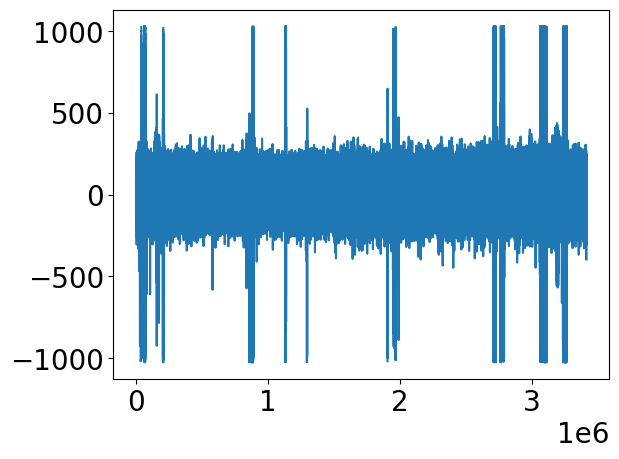

In [44]:
plt.plot(LFP_TRACES_DF["BLA_lfp_trace"].iloc[0])

In [58]:
def get_value_indexes(arr, value=np.nan, min_index=None, max_index=None):
    """
    """
    return np.where(np.isnan(arr[min_index:max_index]))

In [206]:
xmin = 0
xmax = 1000 * 60 * 30

In [231]:
index = 1

In [239]:
threshold = 2

In [249]:
brain_regions = [col.split("_")[0] for col in LFP_TRACES_DF.columns if "trace_filtered" in col]

In [255]:
all_thresholds = [1, 1.5, 2, 2.5, 3]

In [268]:
threshold_dict = {}

(array([  11587.,   20332.,   39223., 1670770., 1494710.,   49848.,
          16643.,   12647.,    8989.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <BarContainer object of 9 artists>)

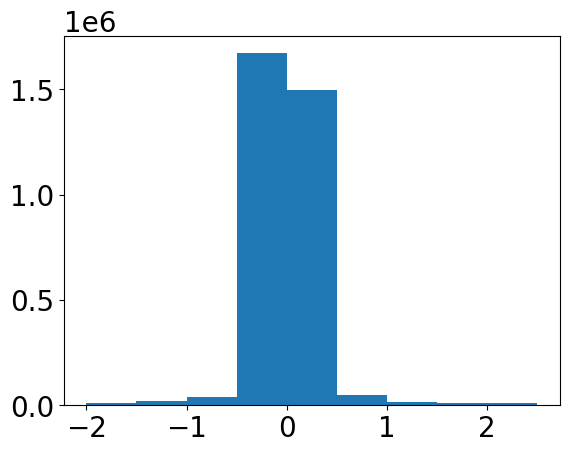

In [274]:
plt.hist(example_zscore, bins=np.arange(int(-2), int(2) + 1, 0.5))


In [277]:
threshold_dict

{0: {'total_samples': 3414668,
  'threshold': 2,
  'z_score_breaks': 98908,
  'region': 'mPFC',
  'recording': '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged',
  'subj': '1.3'}}

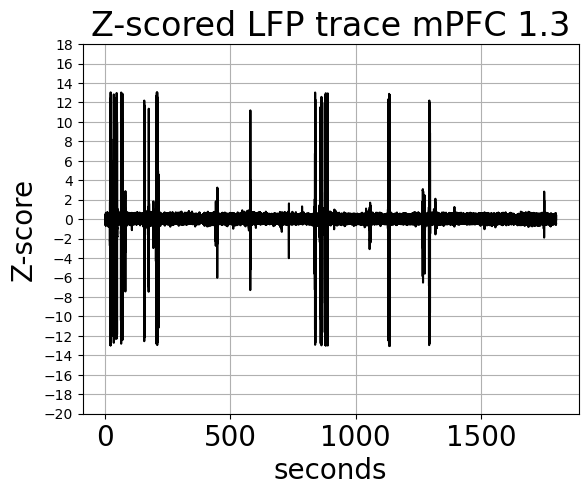

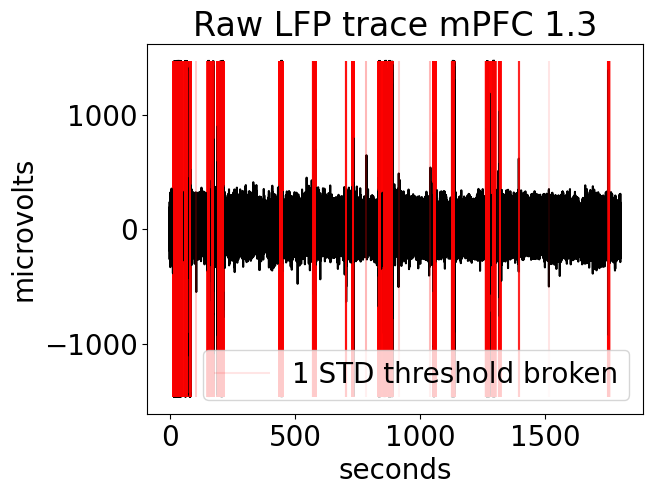

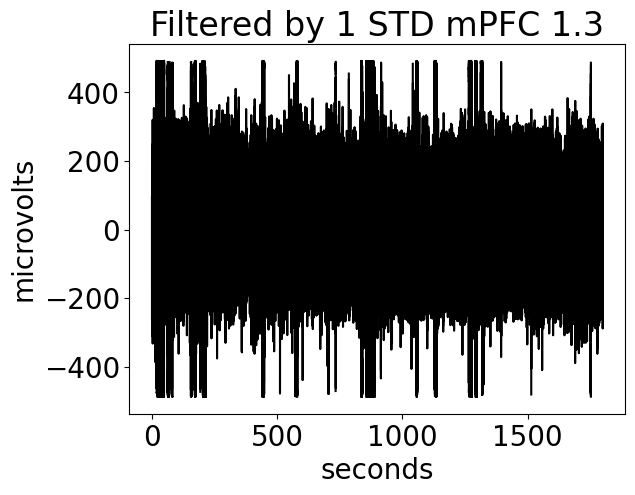

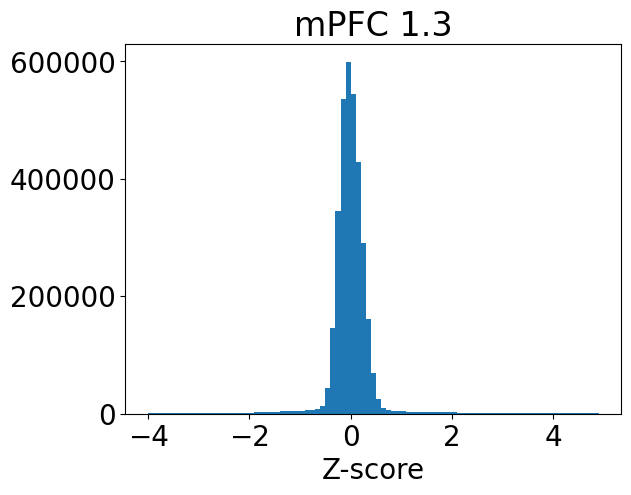

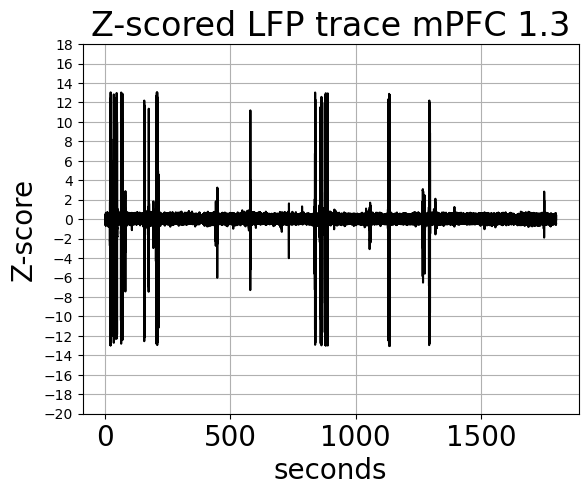

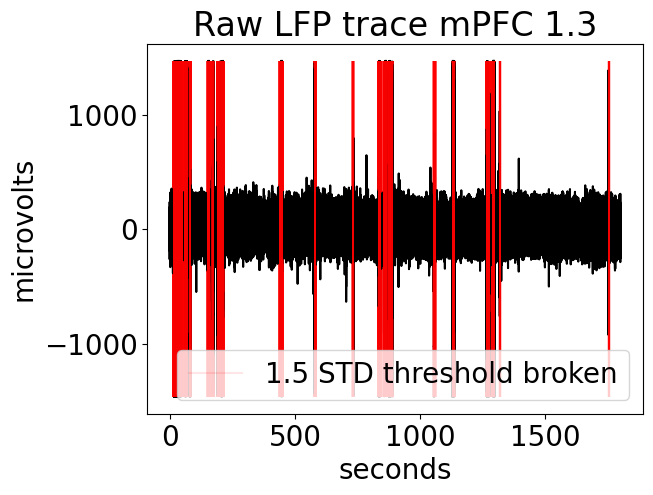

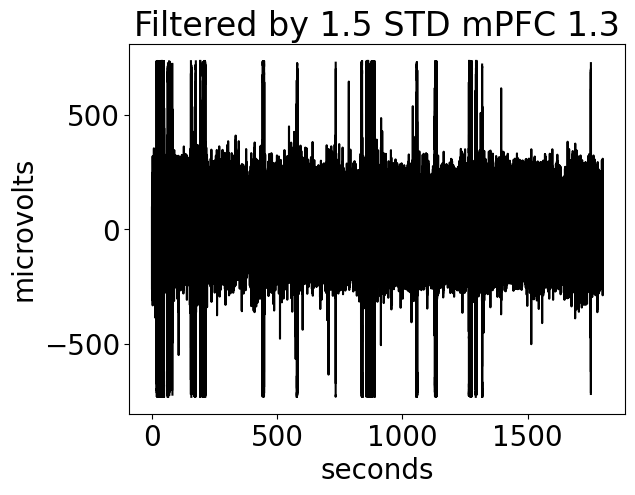

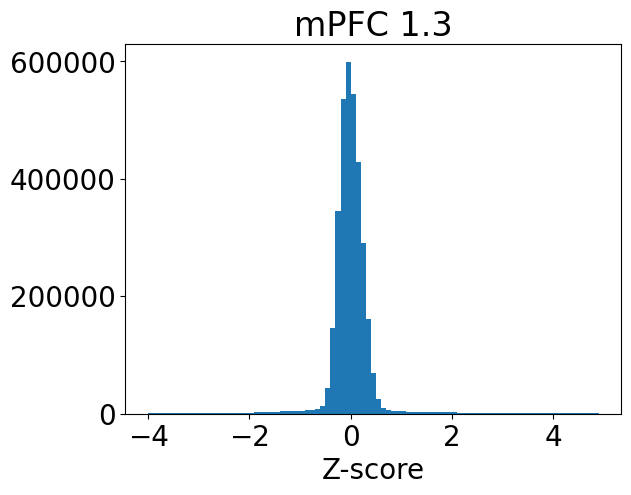

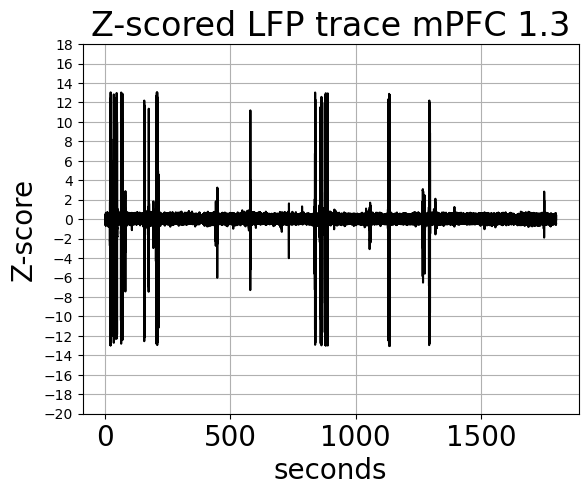

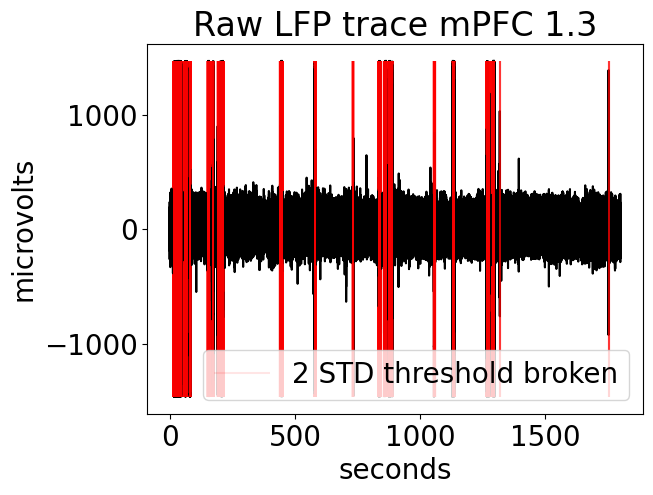

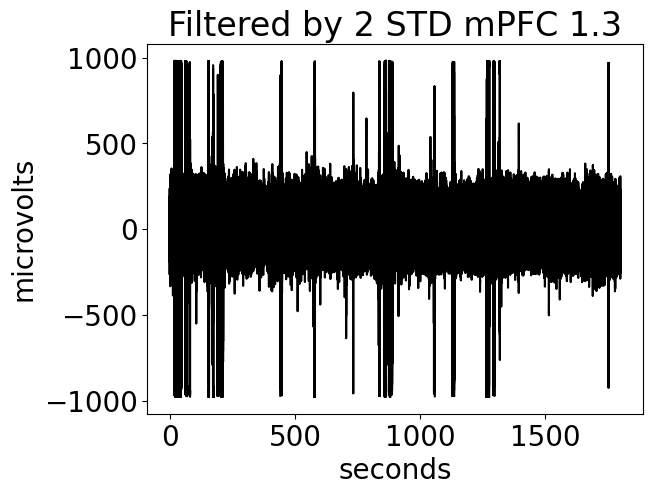

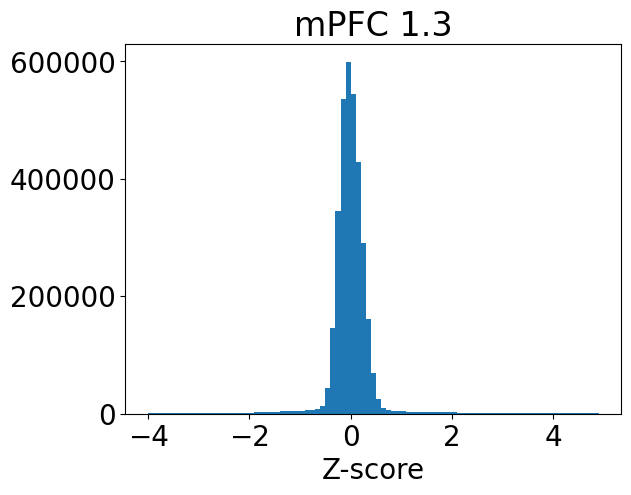

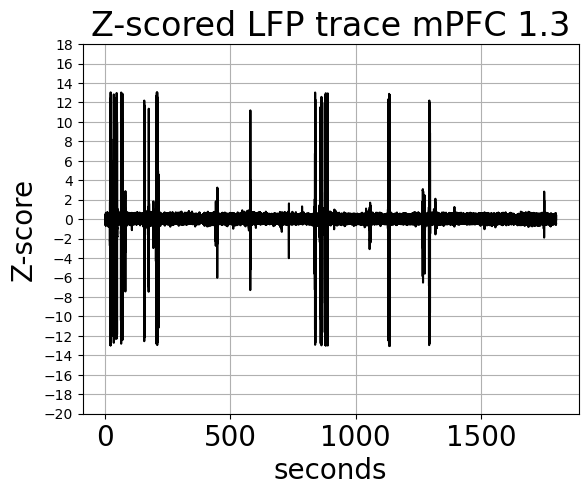

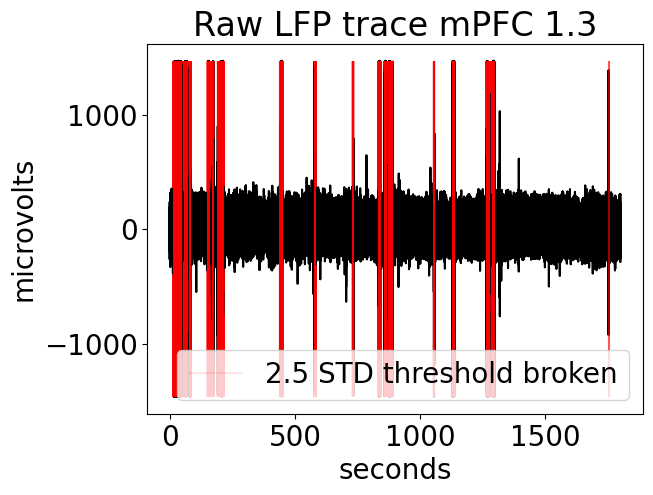

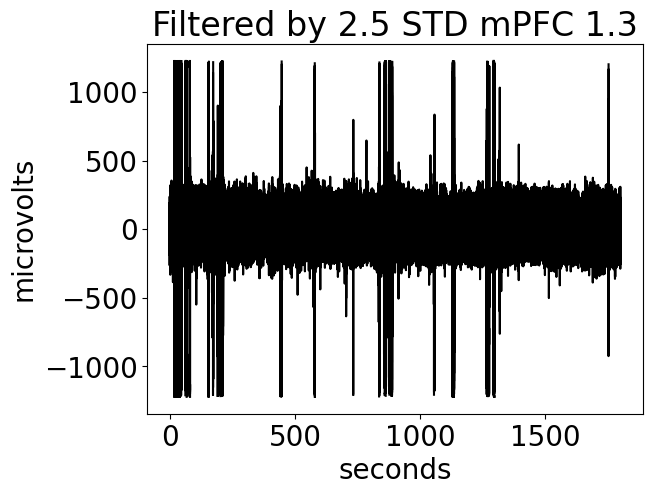

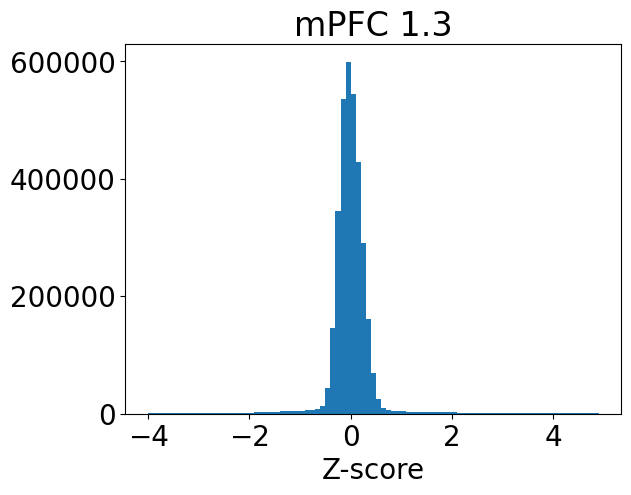

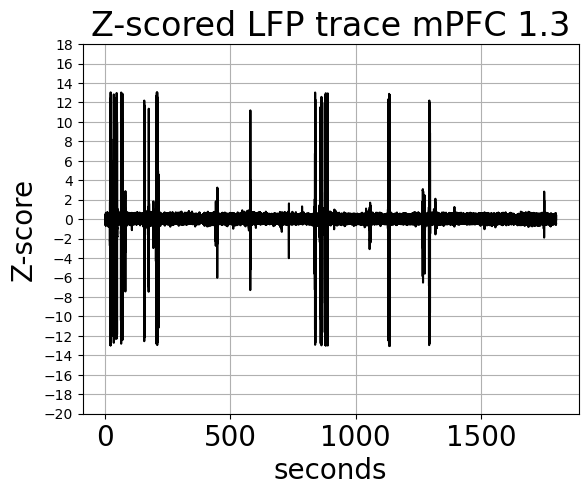

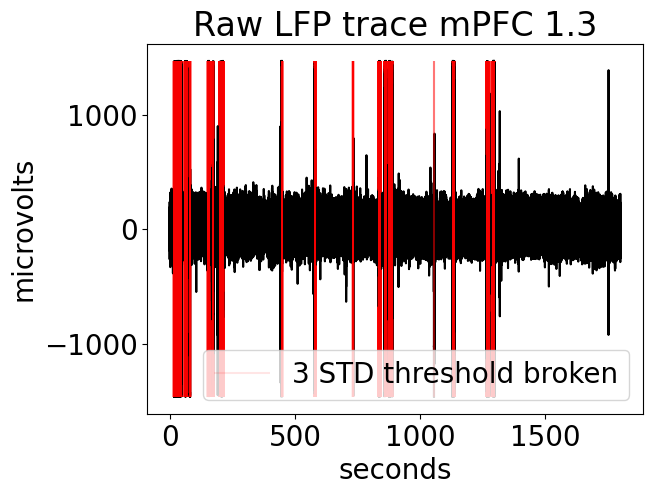

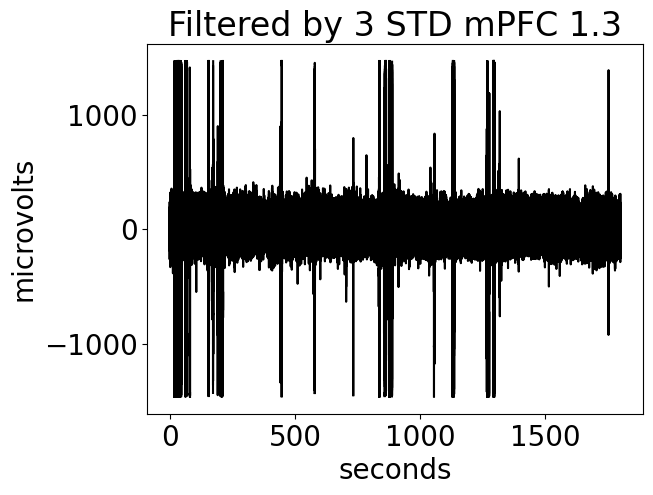

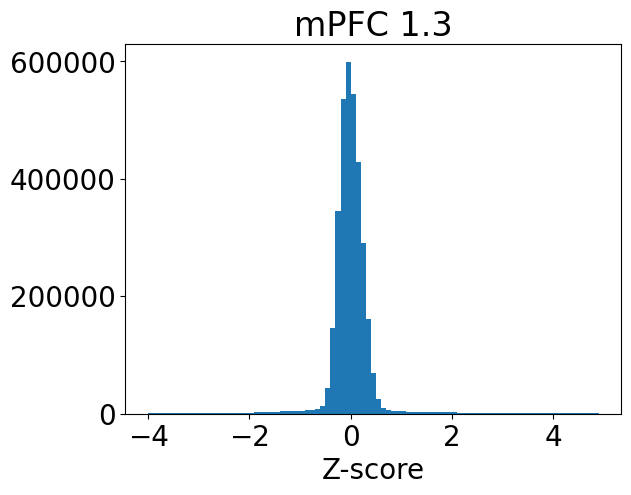

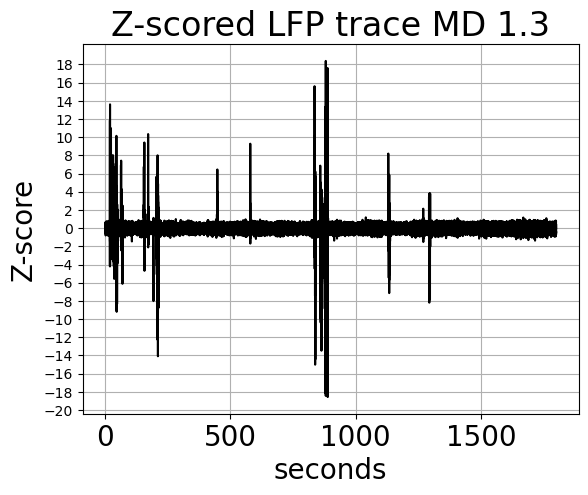

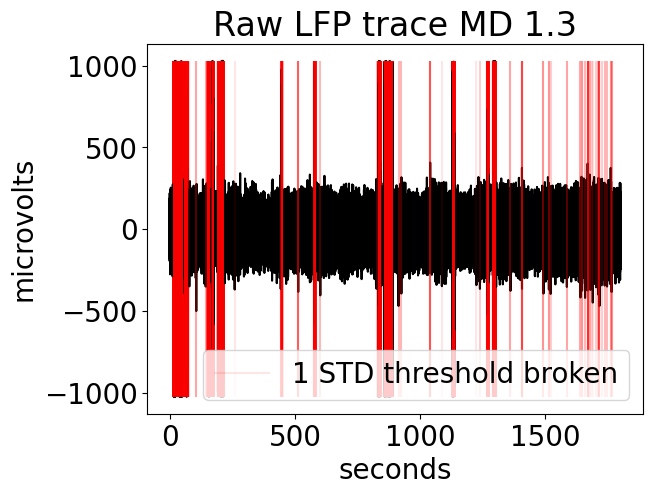

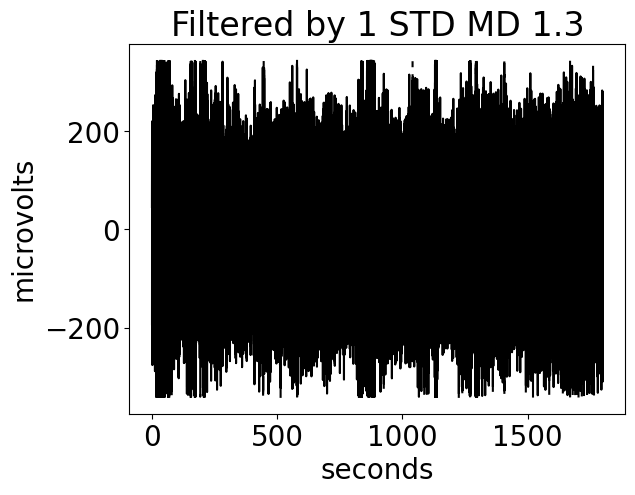

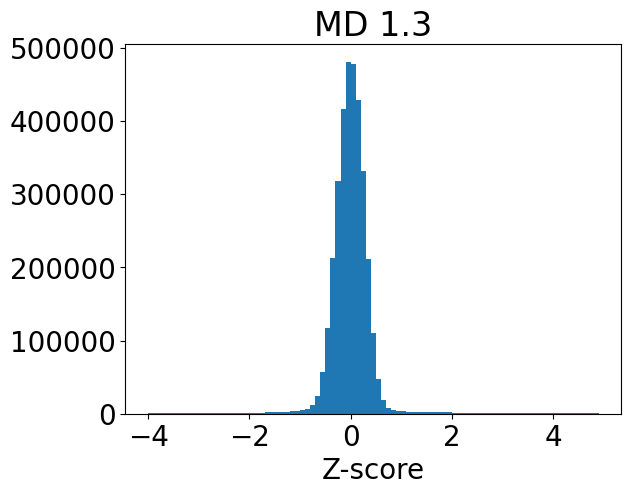

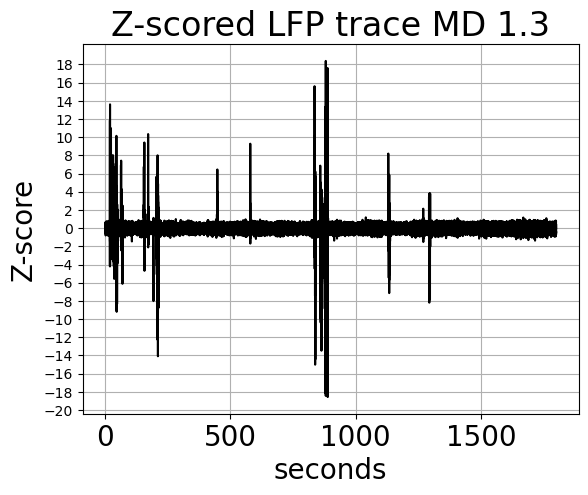

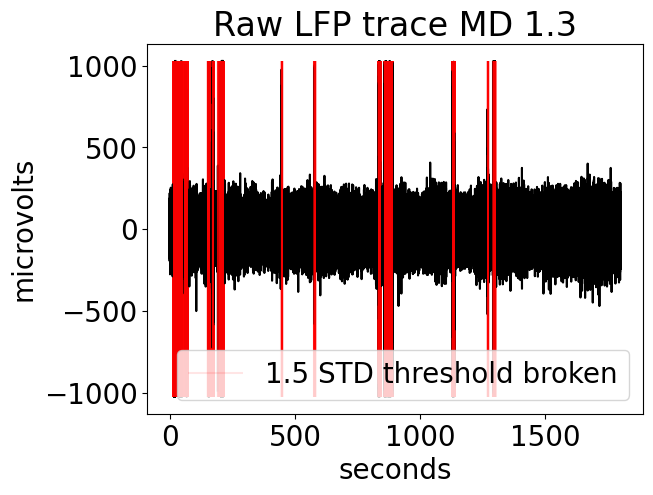

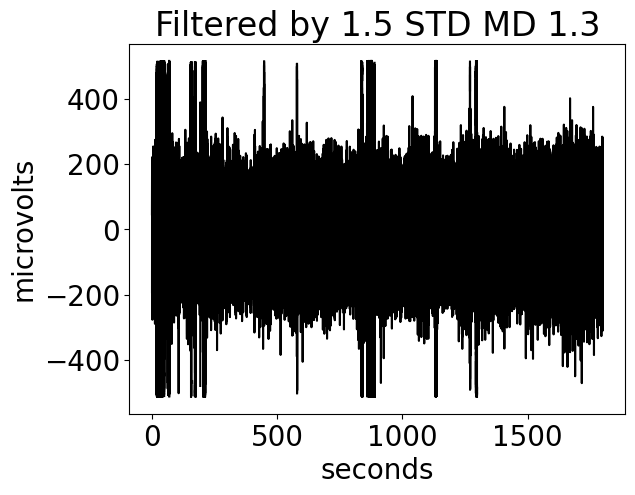

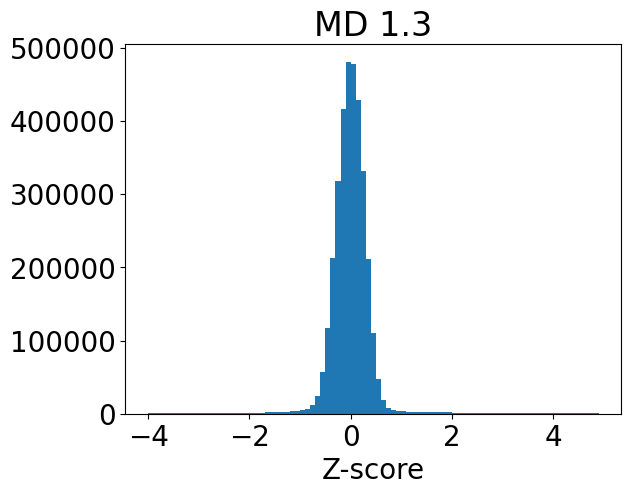

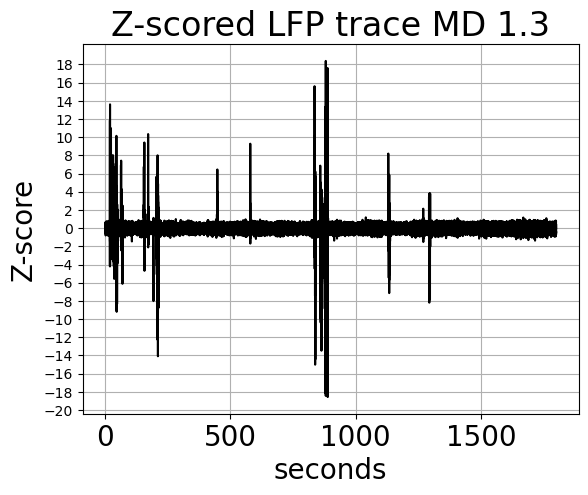

KeyboardInterrupt: 

In [278]:
iteration = 0
for subj in LFP_TRACES_DF["subject"].unique():
    current_df = LFP_TRACES_DF[LFP_TRACES_DF["subject"] == subj].iloc[0]
    for region in brain_regions:
        for threshold in all_thresholds:
            example_zscore = current_df["{}_lfp_zscore".format(region)].copy()
            example_trace = current_df["{}_lfp_trace".format(region)].copy()
            filter_trace = update_array_by_mask(example_trace, np.abs(example_zscore) >= threshold)
            fig, ax = plt.subplots()
            plt.plot(np.arange(xmin, xmax) / 1000, example_zscore[xmin: xmax], color="black")
            plt.grid()
            plt.yticks(np.arange(-20,20, 2.0), size=10)
            plt.title("Z-scored LFP trace {} {}".format(region, subj))
            plt.ylabel("Z-score")
            plt.xlabel("seconds")
            plt.savefig("./proc/preprocessing_plots/{}_{}_zscored_trace.png".format(region, subj))
            plt.show()
            
            fig, ax = plt.subplots()
            plt.title("Raw LFP trace {} {}".format(region, subj))
            plt.ylabel("microvolts")
            plt.xlabel("seconds")
            plt.plot(np.arange(xmin, xmax) / 1000, example_trace[xmin: xmax], color="black")
            plt.vlines(np.where(np.abs(example_zscore[xmin: xmax]) >= threshold)[0] / 1000, ymin=min(example_trace[xmin: xmax]), ymax=max(example_trace[xmin: xmax]), color="red", alpha=0.1, label="{} STD threshold broken".format(threshold))
            plt.legend()
            plt.savefig("./proc/preprocessing_plots/{}std_{}_{}_raw_trace.png".format(threshold, region, subj))
            plt.show()
            
            fig, ax = plt.subplots()
            plt.title("Filtered by {} STD {} {}".format(threshold, region, subj))
            plt.ylabel("microvolts")
            plt.xlabel("seconds")
            plt.plot(np.arange(xmin, xmax) / 1000, filter_trace[xmin: xmax], color="black")
            plt.savefig("./proc/preprocessing_plots/{}std_{}_{}_filtered_trace.png".format(threshold, region, subj))
            plt.show()
            
            fig, ax = plt.subplots()
            plt.title("{} {}".format(region, subj))
            plt.hist(example_zscore, bins=np.arange(int(-4), int(4) + 1, 0.1))
            plt.xlabel("Z-score")
            plt.savefig("./proc/preprocessing_plots/{}_{}_zscore_histogram.png".format(region, subj))
            plt.show()

            threshold_dict[iteration] = {"total_samples": len(example_zscore), "threshold": threshold, "z_score_breaks": sum(np.isnan(filter_trace)), "region": region, "recording": current_df["recording"], "subj": subj}
            iteration += 1

In [41]:
raise ValueError()

ValueError: 

## Calculating phase of signals

- Filtering for theta and gamma

In [ ]:
RMS_columns = [col for col in LFP_TRACES_DF if "RMS" in col and "filtered" not in col]

In [ ]:
fs = 1000
order=4

In [ ]:
freq_band = [4, 12]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [ ]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_theta_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

In [ ]:
freq_band = [30, 50]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [ ]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_gamma_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

- Calculating the phase

In [ ]:
band_columns = [col for col in LFP_TRACES_DF if "band" in col]

In [ ]:
band_columns

In [ ]:
for col in band_columns:
    print(col)
    brain_region = col.replace("_band", "")
    updated_column = "{}_phase".format(brain_region)
    print(updated_column)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.angle(hilbert(x), deg=False))

In [ ]:
LFP_TRACES_DF[col]

In [ ]:
plt.plot(LFP_TRACES_DF["BLA_theta_band"].iloc[0][:1000])
plt.plot(LFP_TRACES_DF["BLA_theta_phase"].iloc[0][:1000])

In [ ]:
plt.plot(LFP_TRACES_DF["BLA_gamma_band"].iloc[0][:300])
plt.plot(LFP_TRACES_DF["BLA_gamma_phase"].iloc[0][:300])

In [ ]:
LFP_TRACES_DF.columns

In [ ]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/rce_pilot_2_02_full_spectral.pkl")
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

In [ ]:
raise ValueError()